In [1]:
import os

# Use the current notebook directory as the project root
project_root = os.getcwd()
os.chdir(project_root)

print("Working directory set to:", os.getcwd())

Working directory set to: /Users/zhangjiuyue/jupternotebook/king's project


In [11]:
import os
import numpy as np
import librosa
import pandas as pd
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from tqdm import tqdm

# Path Configuration
human_dir = os.path.join("./data/whole/real music/")
mureka_dir = os.path.join("./data/whole/generated music/mureka/")
udio_dir = os.path.join("./data/whole/generated music/Udio/")
output_dir = os.path.join("./outputs/")
os.makedirs(output_dir, exist_ok=True)

SAMPLE_RATE = 44100
N_MFCC = 13
PROMPTS = range(1, 6)  # 1~5

# Two templates for generating file names
sample_names = ["{n}.mp3", "{n}(1).mp3"]  # 1.mp3, 1(1).mp3

def extract_features(wav_path):
    """提取MFCC及其delta特征"""
    try:
        y, sr = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)
        y = librosa.util.normalize(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=2048, hop_length=512)
        delta = librosa.feature.delta(mfcc)
        return np.vstack([mfcc, delta]).T
    except Exception as e:
        print(f"Feature extraction failed for {os.path.basename(wav_path)}: {str(e)}")
        return None

def calculate_mcd(feat_ref, feat_target):
    """Calculate MCD after alignment with DTW"""
    if feat_ref is None or feat_target is None:
        return np.nan
    try:
        feat_ref = (feat_ref - np.mean(feat_ref, axis=0)) / (np.std(feat_ref, axis=0) + 1e-8)
        feat_target = (feat_target - np.mean(feat_target, axis=0)) / (np.std(feat_target, axis=0) + 1e-8)
        _, path = fastdtw(feat_ref, feat_target, dist=euclidean, radius=10)
        aligned_ref = np.array([feat_ref[i] for i, _ in path])
        aligned_target = np.array([feat_target[j] for _, j in path])
        return 10 / np.log(10) * np.mean(np.linalg.norm(aligned_ref - aligned_target, axis=1))
    except Exception as e:
        print(f"MCD calculation failed: {str(e)}")
        return np.nan

# Master Analysis Process
def compare_models():
    results = []
    for prompt in tqdm(PROMPTS, desc="Processing Prompts"):
        # real music
        human_file = f"{prompt}.mp3"
        human_path = os.path.join(human_dir, human_file)
        if not os.path.exists(human_path):
            print(f"Missing human file: {human_file}")
            continue
        feat_human = extract_features(human_path)
        if feat_human is None:
            continue
        for model, model_dir in [("Mureka", mureka_dir), ("Udio", udio_dir)]:
            for i, fname_tmpl in enumerate(sample_names, 1):
                ai_file = fname_tmpl.format(n=prompt)
                ai_path = os.path.join(model_dir, ai_file)
                if not os.path.exists(ai_path):
                    print(f"Missing {model} file: {ai_file}")
                    continue
                feat_ai = extract_features(ai_path)
                mcd = calculate_mcd(feat_human, feat_ai)
                results.append({
                    "Prompt": prompt,
                    "Model": model,
                    "Sample": i,  # 1 or 2
                    "MCD": mcd,
                    "Human_File": human_file,
                    "AI_File": ai_file
                })
    return pd.DataFrame(results)

df = compare_models()
df.to_csv(os.path.join(output_dir, "mcd_model_comparison_full.csv"), index=False)
print("✅ Analysis complete. Results saved to:", output_dir)

Processing Prompts: 100%|█████████████████████████| 5/5 [04:34<00:00, 54.87s/it]

✅ Analysis complete. Results saved to: ./outputs/


In [13]:
# 1. Descriptive statistics by model
print(df.groupby('Model')['MCD'].describe())

        count       mean       std        min        25%        50%  \
Model                                                                 
Mureka   10.0  25.010310  1.869953  22.187576  23.724118  25.142984   
Udio     10.0  23.246571  0.605342  22.523648  22.743180  23.045722   

              75%        max  
Model                         
Mureka  26.681407  27.442821  
Udio    23.838328  24.117847  


In [14]:
# 2. By Prompt, Model Mean and Variance
print(df.groupby(['Prompt', 'Model'])['MCD'].agg(['mean', 'std']))

                    mean       std
Prompt Model                      
1      Mureka  23.735542  0.032312
       Udio    23.154227  0.670454
2      Mureka  25.142984  1.030329
       Udio    22.876781  0.091669
3      Mureka  22.488533  0.425618
       Udio    22.621951  0.139021
4      Mureka  26.515118  0.470336
       Udio    23.946051  0.053340
5      Mureka  27.169374  0.386712
       Udio    23.633845  0.684483


In [15]:
# 3. Stability analysis: MCD difference and variance for two songs of the same model under the same prompt
stability_results = []
for prompt in PROMPTS:
    for model in ['Mureka', 'Udio']:
        mcds = df[(df['Prompt'] == prompt) & (df['Model'] == model)]['MCD'].values
        if len(mcds) == 2:
            diff = abs(mcds[0] - mcds[1])
            std = np.std(mcds)
            stability_results.append({'Prompt': prompt, 'Model': model, 'MCD_Diff': diff, 'MCD_Std': std})
stability_df = pd.DataFrame(stability_results)
print(stability_df)

   Prompt   Model  MCD_Diff   MCD_Std
0       1  Mureka  0.045696  0.022848
1       1    Udio  0.948166  0.474083
2       2  Mureka  1.457105  0.728552
3       2    Udio  0.129639  0.064820
4       3  Mureka  0.601915  0.300958
5       3    Udio  0.196605  0.098302
6       4  Mureka  0.665155  0.332578
7       4    Udio  0.075434  0.037717
8       5  Mureka  0.546894  0.273447
9       5    Udio  0.968005  0.484002


In [16]:
# 4. Paired t-test (paired per prompt model means)
from scipy.stats import ttest_rel
pivot_df = df.groupby(['Prompt', 'Model'])['MCD'].mean().unstack()
if all(col in pivot_df.columns for col in ['Mureka', 'Udio']):
    t_stat, p_value = ttest_rel(pivot_df['Mureka'], pivot_df['Udio'])
    print(f"Paired t-test: t={t_stat:.3f}, p={p_value:.4f}")

Paired t-test: t=2.624, p=0.0586


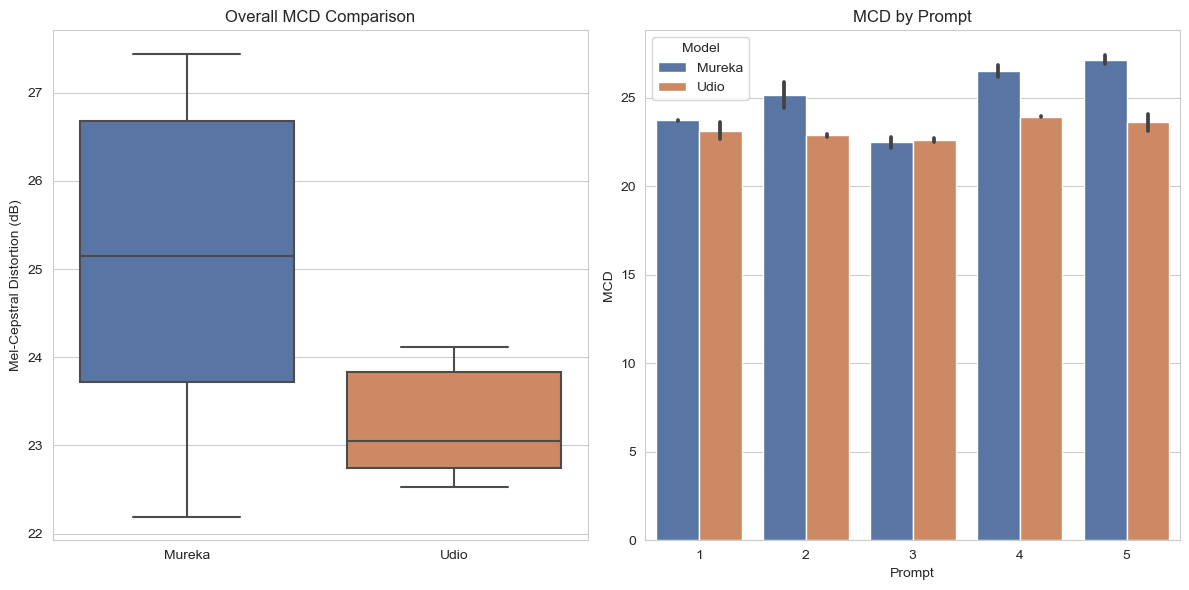

In [17]:
# 5. Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
palette = {"Mureka": "#4C72B0", "Udio": "#DD8452"}

plt.subplot(1, 2, 1)
sns.boxplot(x="Model", y="MCD", data=df, palette=palette)
plt.title("Overall MCD Comparison")
plt.xlabel("")
plt.ylabel("Mel-Cepstral Distortion (dB)")

plt.subplot(1, 2, 2)
sns.barplot(x="Prompt", y="MCD", hue="Model", data=df, palette=palette)
plt.title("MCD by Prompt")
plt.legend(title="Model")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "mcd_model_comparison.png"), dpi=300)
plt.show()